Done till t_index=0, N=4, hx=1, hz=1, time=0.00s


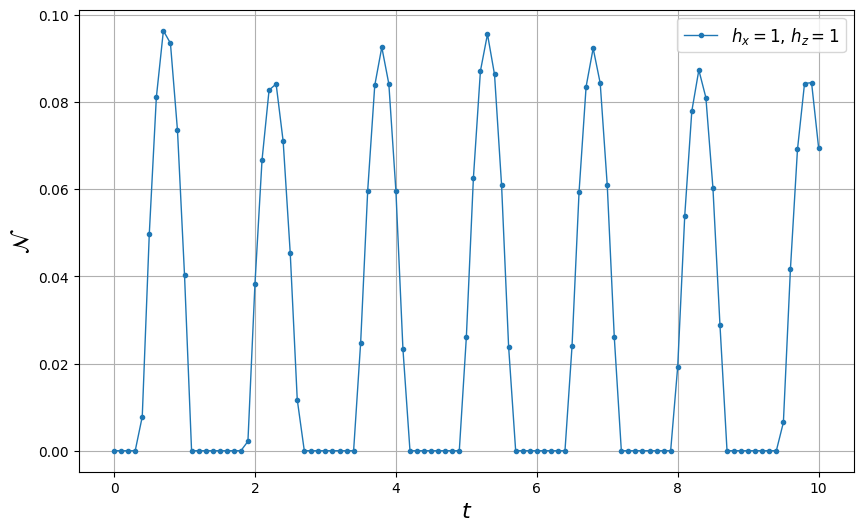

In [5]:
import numpy as np
from scipy.linalg import expm, eigh
from numpy import kron
import matplotlib.pyplot as plt
import time

# ---------- Pauli matrices ----------
sx = np.array([[0, 1], [1, 0]], dtype=complex)
sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
sz = np.array([[1, 0], [0, -1]], dtype=complex)
id2 = np.eye(2, dtype=complex)

# ---------- Kronecker embedding ----------
def embed(op, site, N):
    """Embed single-site operator op at position site (1-indexed)."""
    ops = [op if i == site else id2 for i in range(1, N+1)]
    O = ops[0]
    for k in range(1, N):
        O = kron(O, ops[k])
    return O

# ---------- TFIM Hamiltonian ----------
def TFIM(N, J, hz, hx):
    Hxx = np.zeros((2**N, 2**N), dtype=complex)
    Hz  = np.zeros((2**N, 2**N), dtype=complex)
    Hx  = np.zeros((2**N, 2**N), dtype=complex)

    for i in range(1, N):
        Hxx += embed(sx, i, N) @ embed(sx, i+1, N)

    for i in range(1, N+1):
        Hz += embed(sz, i, N)
        Hx += embed(sx, i, N)

    H = -J*Hxx - hz*Hz - hx*Hx
    return H, Hxx, Hz, Hx

# ---------- Projectors ----------
zu = np.array([[1], [0]], dtype=complex)
zd = np.array([[0], [1]], dtype=complex)
Pzu = zu @ zu.conj().T
Pzd = zd @ zd.conj().T
def PZu(i): return embed(Pzu, i, N)
def PZd(i): return embed(Pzd, i, N)

# X-basis single-spin states
xu = np.array([[1], [1]], dtype=complex) / np.sqrt(2)
xd = np.array([[1], [-1]], dtype=complex) / np.sqrt(2)
# Projectors
Pxu = xu @ xu.conj().T
Pxd = xd @ xd.conj().T
# Functions to embed projectors at site i
def PXu(i): return embed(Pxu, i, N)

def PXd(i): return embed(Pxd, i, N)


# ---------- Parameters ----------
L = 4
N = L
J = 1
hz_list = [1]
hx_list = [1]
dt = 0.1
tt = np.arange(0, 10+dt, dt)

# ---------- Loop over hx, hz ----------
plt.figure(figsize=(10,6))

for hz in hz_list:
    for hx in hx_list:

        start_time = time.time()

        # Hamiltonian
        H, Hxx, Hz_mat, Hx_mat = TFIM(N, J, hz, hx)

        # Ground state
        eigvals, eigvecs = eigh(H)
        ground_state = eigvecs[:, np.argmin(eigvals)]
        S0 = ground_state

        # Operators
        V1 = PXu(1)
        V2 = PXd(1)
        W1 = PXu(1)
        W2 = PXd(1)

        Ne = np.zeros(len(tt))

        for ti, t in enumerate(tt):
            U = expm(-1j*H*t)
            PP = 0
            for i in [1,2]:
                for j in [1,2]:
                    if i==1 and j==1:
                        V, W = V1, W1
                    elif i==1 and j==2:
                        V, W = V1, W2
                    elif i==2 and j==1:
                        V, W = V2, W1
                    elif i==2 and j==2:
                        V, W = V2, W2

                    Vt = U.conj().T @ V @ U
                    # Quasiprobability contribution
                    P = np.abs(np.real(S0.conj().T @ Vt @ W @ S0))
                    PP += P

            Ne[ti] = PP

            if ti % 500 == 0:
                print(f"Done till t_index={ti}, N={N}, hx={hx}, hz={hz}, time={time.time()-start_time:.2f}s")

        plt.plot(tt, Ne-1, '-o', markersize=3, linewidth=1, label=f"$h_x={hx}$, $h_z={hz}$")

# ---------- Plot formatting ----------
plt.xlabel(r"$t$", fontsize=16)
plt.ylabel(r"$\mathcal{N}$", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
